In [1]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument

import sys
sys.path.insert(0,'..')


In [12]:
#imports 
import os
import nltk
import spacy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.onnx as onnx
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torch.utils.data import DataLoader,Dataset
from PIL import Image
from tqdm import tqdm
from time import sleep

from src.baseline.vocabulary import Vocabulary
from src.baseline.data_loader import get_loader, get_mean_std
from src.utils import print_time, list_of_tensors_to_numpy_arr
from src.accuracy import Accuracy
from src.baseline.coa_model import load_model, train_validate_test_split

from pyinstrument import Profiler
from datetime import datetime
from shutil import copyfile


# Create test-caption file from cropped folder  

### Setting Hypperparameter and Init the model

In [9]:
#Hyperparams
embed_size=300
vocab_size = 36
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4
drop_prob=0.3
ignored_idx = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hyper_params = {'embed_size': embed_size,
                'attention_dim': attention_dim,
                'encoder_dim': encoder_dim,
                'decoder_dim': decoder_dim,
                'vocab_size': vocab_size
              }

In [10]:
from src.baseline.coa_model import load_model

model_path = '../models/baseline/attention_model_03.14.2022-22:14:21.pth'

model, optimizer, loss = load_model(model_path, hyper_params, learning_rate, drop_prob, ignored_idx)

In [13]:

# data_location = '/home/space/datasets/COA/generated-data-api'
# data_location =  '/home/space/datasets/COA/generated-data-api-small'
data_location =  '../baseline-gen-data/medium'
caption_file = data_location + '/captions.txt'
root_folder_images = data_location + '/images'
df = pd.read_csv(caption_file)

train, validate, test = train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None)

test_annotation_file  = data_location + '/test_real_captions.txt'

test.to_csv(test_annotation_file, sep=',',index=False)

print("There are {} total images".format(len(df)))

caption_file = data_location + '/test_captions.txt'
df3 = pd.read_csv(caption_file)
print("There are {} test images".format(len(df3)))

There are 720 total images
There are 144 test images


Caption: image_1.png A A lion
(500, 500, 4)


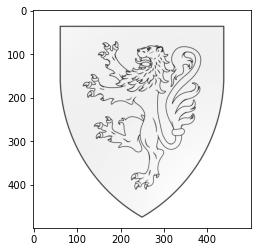

In [14]:
for i in range(1, 2):
    image_path = data_location + '/images/'+ df.iloc[i,0]
    print("Caption:", df.iloc[i,0], df.iloc[i,1])
    img=mpimg.imread(image_path)
    print(img.shape)
    plt.imshow(img)
    plt.show()


In [15]:
!export CUDA_VISIBLE_DEVICES=0
!export CUDA_LAUNCH_BLOCKING=1

In [16]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cpu')

In [ ]:
torch.cuda.get_device_name(0)

In [17]:
# BATCH_SIZE = 5
NUM_WORKER = 2 #### this needs multi-core
freq_threshold = 5
# 30 minutes to create those, as it's baseline, i ran it several times and it's the same
vocab = Vocabulary(freq_threshold)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, 'head': 8, 'lions': 9, 'cross': 10, 'moline': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'eagles': 15, 'a': 16, 'b': 17, 'o': 18, 's': 19, 'g': 20, 'e': 21, 'v': 22, '1': 23, '2': 24, '3': 25, '4': 26, '5': 27, '6': 28, '7': 29, '8': 30, '9': 31, '10': 32, '11': 33, 'border': 34, '&': 35}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'lion', 5: 'rampant', 6: 'passt', 7: 'guard', 8: 'head', 9: 'lions', 10: 'cross', 11: 'moline', 12: 'patonce', 13: 'eagle', 14: 'doubleheaded', 15: 'eagles', 16: 'a', 17: 'b', 18: 'o', 19: 's', 20: 'g', 21: 'e', 22: 'v', 23: '1', 24: '2', 25: '3', 26: '4', 27: '5', 28: '6', 29: '7', 30: '8', 31: '9', 32: '10', 33: '11', 34: 'border', 35: '&'}

# old before extending to multi object, plural and border
# vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'g': 4, 'v': 5, 'b': 6, 'cross': 7, 'lion': 8, 'passt': 9, 's': 10, 'a': 11, 'eagle': 12, 'o': 13, 'doubleheaded': 14, "'s": 15, 'head': 16, 'patonce': 17, 'moline': 18, 'guard': 19, 'rampant': 20}
# vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'g', 5: 'v', 6: 'b', 7: 'cross', 8: 'lion', 9: 'passt', 10: 's', 11: 'a', 12: 'eagle', 13: 'o', 14: 'doubleheaded', 15: "'s", 16: 'head', 17: 'patonce', 18: 'moline', 19: 'guard', 20: 'rampant'}


## Training Job from above configs

In [22]:
!export CUDA_LAUNCH_BLOCKING=1
!export CUDA_VISIBLE_DEVICES=2

# Test the loaded model on real data


In [19]:
batch_size = 256
test_loader, test_dataset = get_loader(
    root_folder=root_folder_images,
    annotation_file=test_annotation_file,
    transform=None,  # <=======================
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=batch_size,
    device=device,
    pin_memory=False
)

mean, std = get_mean_std(test_dataset, test_loader, 500 , 500)
print('mean, std:', mean, std)

#defining the transform to be applied

transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(mean, std) 
])

test_loader, test_dataset = get_loader(
    root_folder=root_folder_images,
    annotation_file=test_annotation_file,
    transform=transform,  # <=======================
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=batch_size,
    device=device,
    pin_memory=False
)


mean, std: tensor(0.8170) tensor(1.1083)


In [20]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
test_losses=[]
accuracy_test_list=[]

model.eval()
with torch.no_grad():
    for idx, (img, correct_cap) in enumerate(iter(test_loader)):
        features = model.encoder(img.to(device))

        features_tensors = img[0].detach().clone().unsqueeze(0)
        features = model.encoder(features_tensors.to(device))

        caps,_ = model.decoder.generate_caption(features, vocab=val_dataset.vocab)   
        caps = caps[:-1]
        predicted_caption = ' '.join(caps)
        
        # compare predictions to true label
        correct_caption = []
        for j in correct_cap.T[0]:
            if j.item() not in [0, 1, 2 , 3]:
                correct_caption.append(val_dataset.vocab.itos[j.item()])
        correct_caption_s = ' '.join(correct_caption)
        
        # calc metrics
        acc_test = Accuracy(predicted_caption,correct_caption_s).get()
        accuracy_test_list.append(acc_test)
        print(f'Test Acuuracy (in progress): {acc_test:.6f}\n')

        # ------------------------------------------
        # calc losses and take the average 
        image, captions = img.to(device), correct_cap.to(device)
        outputs, _ = model(image, captions.T)
        targets    = captions.T[:,1:] 
        loss       = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        test_losses.append(loss)

        # ------------------------------------------

# calculate and print avg test loss
test_loss = sum(test_losses)/len(test_dataset)
print('Test Loss (final): {:.6f}\n'.format(test_loss))

acc_test_score = (100. * sum(accuracy_test_list) / len(accuracy_test_list))

print(f'Test Accuracy (Overall): {acc_test_score}%')


NameError: name 'val_dataset' is not defined

##  Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [42]:
#generate caption
def get_caps_from(model, features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=test_dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas
#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()
    
def test_rand_image(model, test_loader):
    dataiter = iter(test_loader)
    images,_ = next(dataiter)

    img = images[0].detach().clone()
    img1 = images[0].detach().clone()
    caps,alphas = get_caps_from(model, img.unsqueeze(0))

    plot_attention(img1, caps, alphas)

    #show the tensor image
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
      
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


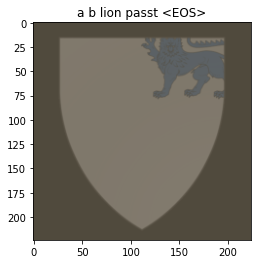

ValueError: num must be 1 <= num <= 4, not 5

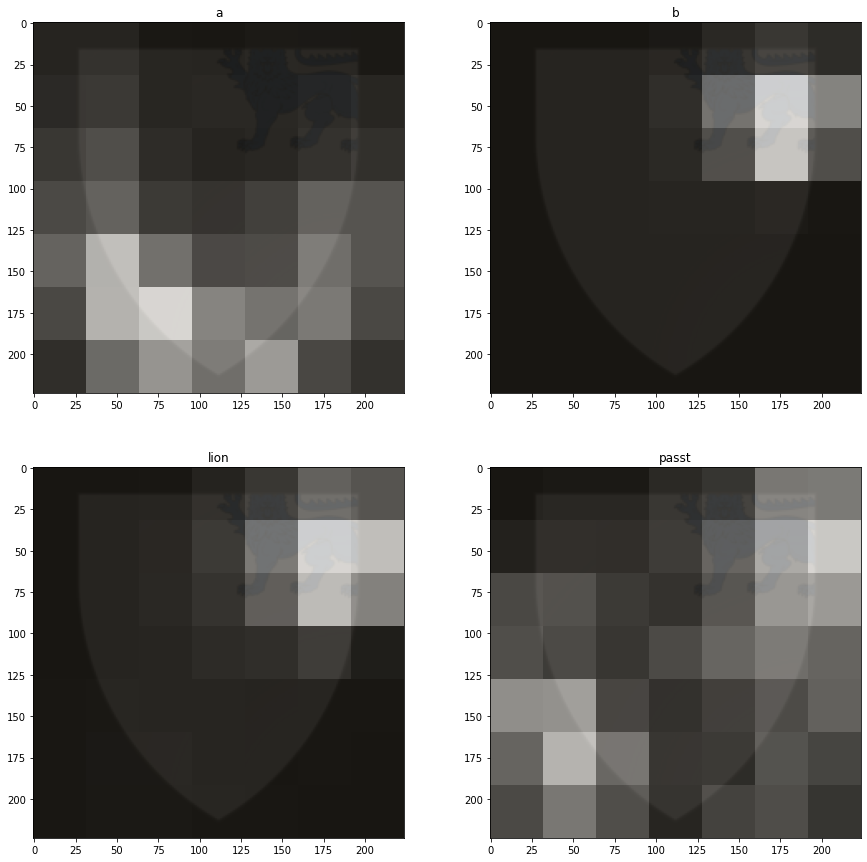

In [44]:
# torch.cuda.empty_cache()

# model_path = '/home/space/datasets/COA/models/baseline/attention_model_state.pth'
# local_model_path = 'simple-model.pth'
# model = load_model(local_model_path)
test_rand_image(model,test_loader)